In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
class AdaptiveUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(AdaptiveUNet, self).__init__()
        
        # Энкодер
        self.encoder1 = self._block(in_channels, init_features)
        self.pool1 = nn.AdaptiveMaxPool2d((64, 128))  # Адаптивный пулинг
        self.encoder2 = self._block(init_features, init_features * 2)
        self.pool2 = nn.AdaptiveMaxPool2d((32, 64))   # Адаптивный пулинг
        self.encoder3 = self._block(init_features * 2, init_features * 4)
        self.pool3 = nn.AdaptiveMaxPool2d((16, 32))   # Адаптивный пулинг
        self.encoder4 = self._block(init_features * 4, init_features * 8)
        self.pool4 = nn.AdaptiveMaxPool2d((8, 16))    # Адаптивный пулинг

        # Боттлнек
        self.bottleneck = self._block(init_features * 8, init_features * 16)

        # Декодер
        self.upconv4 = nn.ConvTranspose2d(init_features * 16, init_features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block(init_features * 16, init_features * 8)
        self.upconv3 = nn.ConvTranspose2d(init_features * 8, init_features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(init_features * 8, init_features * 4)
        self.upconv2 = nn.ConvTranspose2d(init_features * 4, init_features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(init_features * 4, init_features * 2)
        self.upconv1 = nn.ConvTranspose2d(init_features * 2, init_features, kernel_size=2, stride=2)
        self.decoder1 = self._block(init_features * 2, init_features)

        # Выходной слой
        self.conv = nn.Conv2d(init_features, out_channels, kernel_size=1)

    def forward(self, x):
        # Энкодер
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Боттлнек
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Декодер
        dec4 = self.upconv4(bottleneck)
        dec4 = self._adjust_size(dec4, enc4)  # Корректируем размер
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self._adjust_size(dec3, enc3)  # Корректируем размер
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self._adjust_size(dec2, enc2)  # Корректируем размер
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self._adjust_size(dec1, enc1)  # Корректируем размер
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Выход
        return torch.sigmoid(self.conv(dec1))

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def _adjust_size(self, tensor, target_tensor):
        """
        Корректирует размер tensor до размера target_tensor.
        """
        if tensor.size()[2:] != target_tensor.size()[2:]:
            tensor = F.interpolate(tensor, size=target_tensor.size()[2:], mode='bicubic', align_corners=True)
        return tensor
        

In [2]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_x, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_x, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        # Корректируем размер g1 до размера x1
        if g1.size()[2:] != x1.size()[2:]:
            g1 = F.interpolate(g1, size=x1.size()[2:], mode='bicubic', align_corners=True)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [3]:
class AdaptiveUNetAttencion(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super().__init__()
        
        # Энкодер (без изменений)
        self.encoder1 = self._block(in_channels, init_features)
        self.pool1 = nn.AdaptiveMaxPool2d((64, 128))  # Адаптивный пулинг
        self.encoder2 = self._block(init_features, init_features * 2)
        self.pool2 = nn.AdaptiveMaxPool2d((32, 64))   # Адаптивный пулинг
        self.encoder3 = self._block(init_features * 2, init_features * 4)
        self.pool3 = nn.AdaptiveMaxPool2d((16, 32))   # Адаптивный пулинг
        self.encoder4 = self._block(init_features * 4, init_features * 8)
        self.pool4 = nn.AdaptiveMaxPool2d((8, 16))    # Адаптивный пулинг

        # Боттлнек (без изменений)
        self.bottleneck = self._block(init_features * 8, init_features * 16)

        # Декодер (без изменений)
        self.upconv4 = nn.ConvTranspose2d(init_features * 16, init_features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block(init_features * 16, init_features * 8)
        self.upconv3 = nn.ConvTranspose2d(init_features * 8, init_features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(init_features * 8, init_features * 4)
        self.upconv2 = nn.ConvTranspose2d(init_features * 4, init_features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(init_features * 4, init_features * 2)
        self.upconv1 = nn.ConvTranspose2d(init_features * 2, init_features, kernel_size=2, stride=2)
        self.decoder1 = self._block(init_features * 2, init_features)

        # Выходной слой (без изменений)
        self.conv = nn.Conv2d(init_features, out_channels, kernel_size=1)

        # Attention Gates
        self.attn4 = AttentionGate(init_features*8, init_features*8, init_features*4)
        self.attn3 = AttentionGate(init_features*4, init_features*4, init_features*2)
        self.attn2 = AttentionGate(init_features*2, init_features*2, init_features)
        self.attn1 = AttentionGate(init_features, init_features, init_features//2)

    def forward(self, x):
        # Энкодер (без изменений)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Боттлнек (без изменений)
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Декодер с Attention
        dec4 = self.upconv4(bottleneck)
        dec4 = self._adjust_size(dec4, enc4)  # Корректируем размер
        enc4 = self.attn4(dec4, enc4)  # Применяем внимание
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self._adjust_size(dec3, enc3)  # Корректируем размер
        enc3 = self.attn3(dec3, enc3)  # Применяем внимание
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self._adjust_size(dec2, enc2)  # Корректируем размер
        enc2 = self.attn2(dec2, enc2)  # Применяем внимание
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self._adjust_size(dec1, enc1)  # Корректируем размер
        enc1 = self.attn1(dec1, enc1)  # Применяем внимание
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Выход (без изменений)
        return torch.sigmoid(self.conv(dec1))

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def _adjust_size(self, tensor, target_tensor):
        """
        Корректирует размер tensor до размера target_tensor.
        """
        if tensor.size()[2:] != target_tensor.size()[2:]:
            tensor = F.interpolate(tensor, size=target_tensor.size()[2:], mode='bicubic', align_corners=True)
        return tensor

In [4]:
class NoisyCleanDataset(DataLoader):
    def __init__(self, noisy_images, clean_images, path_to_folder, transform=None):
        self.noisy_images = noisy_images
        self.clean_images = clean_images
        self.path_to_folder = path_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        path_to_clean = str(Path(self.path_to_folder, self.clean_images[idx]))
        path_to_noisy = str(Path(self.path_to_folder, self.noisy_images[idx]))
        clean_image = Image.open(path_to_clean).convert('L')
        noisy_image = Image.open(path_to_noisy).convert('L')

        if self.transform:
            clean_image = self.transform(clean_image)
            noisy_image = self.transform(noisy_image)
        return noisy_image, clean_image

def custom_collate_fn(batch):
    noisy_images = [item[0] for item in batch]
    clean_images = [item[1] for item in batch]
    return noisy_images, clean_images

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

In [6]:
PATH_TO_DATASET = str(Path(os.getcwd(), "project_C++/Code/results_pictures_dataset"))

images = [f for f in os.listdir(PATH_TO_DATASET) if f.endswith('.png')]

images_pairs = {}

for image in images:
    if 'noisy' in image:
        number = image[3:].split('_')[0] if 'stretched' not in image else image[3:].split('_')[0] + 'stret'
        if number not in images_pairs:
            images_pairs[number] = {}
        images_pairs[number]['noisy'] = image
    else:
        number = image[3:].split('_')[0] + 'stret' if 'stretched' in image else image[3:].split('.')[0]
        if number not in images_pairs:
            images_pairs[number] = {}
        images_pairs[number]['clean'] = image

noisy_images = []
clean_images = []

for pair in images_pairs:
    noisy_images.append(images_pairs[pair]['noisy'])
    clean_images.append(images_pairs[pair]['clean'])


In [7]:
def plot_metrics(train_losses, val_losses=None):
    """
    Функция для построения графиков потерь.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    if val_losses:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
dataset = NoisyCleanDataset(noisy_images, clean_images, PATH_TO_DATASET, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
model = AdaptiveUNetAttencion(in_channels=1, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  

checkpoint = torch.load('checkpoint_epoch_4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = 4

Number of epoch: 5


Batch: 100%|████████████████████████████████████████████████████████████████████| 1987/1987 [11:58:18<00:00, 21.69s/it]


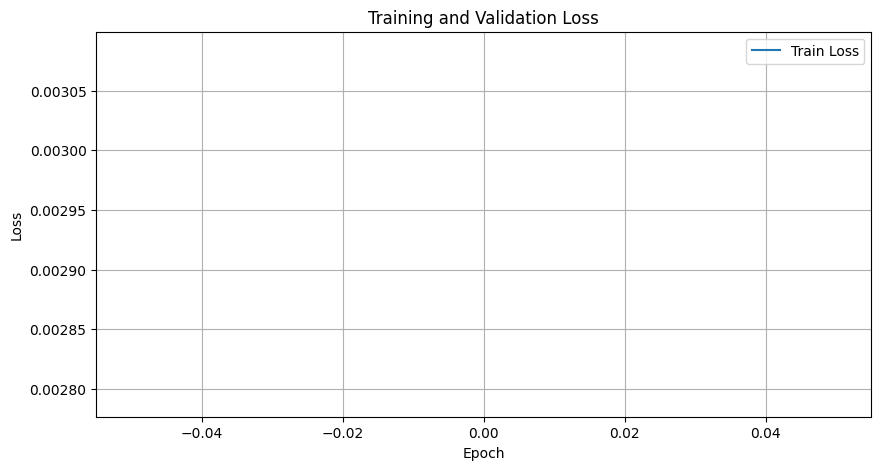

Epoch 5, Loss: 0.002938010567382551
Number of epoch: 6


Batch:  10%|██████▋                                                            | 197/1987 [1:11:04<10:45:52, 21.65s/it]


KeyboardInterrupt: 

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 10
train_losses = []
for epoch in range(start_epoch, n_epochs):
    epoch_loss = 0.0
    print(f"Number of epoch: {epoch + 1}")
    for noisy_batch, clean_batch in tqdm(dataloader, desc='Batch', leave=True):
        # Итерируемся по каждому изображению в батче
        for noisy, clean in zip(noisy_batch, clean_batch):
            # Добавляем batch dimension (если его нет)
            noisy = noisy.unsqueeze(0)  # Теперь размер: [1, C, H, W]
            clean = clean.unsqueeze(0)  # Теперь размер: [1, C, H, W]

            # Перемещаем данные на устройство (например, GPU)
            noisy = noisy.to(device)
            clean = clean.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(noisy)
            loss = criterion(output, clean)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Суммируем loss для вывода
            epoch_loss += loss.item()
            
    epoch_loss /= len(dataloader)
    train_losses.append(epoch_loss)
    
    # torch.save(model.state_dict(), f'model_weights_epoch_{epoch + 1}_attencion.pth')
    checkpoint = {
        'epoch': epoch + 1,  # Сохраняем номер эпохи, начиная с 1
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,  # Сохраняем средний loss за эпоху
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    plot_metrics(train_losses)
    # Выводим средний loss за эпоху
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

In [9]:
epoch_loss

0.01649939088450151

In [13]:
train_losses[0]

0.013092835880333433

In [31]:
train_losses[0] # вторая эпоха

0.006005769819108595

In [11]:
train_losses[0] # третья эпоха

0.0044857156334741

In [11]:
train_losses[0] # пятая эпоха

0.002938010567382551

# Test model

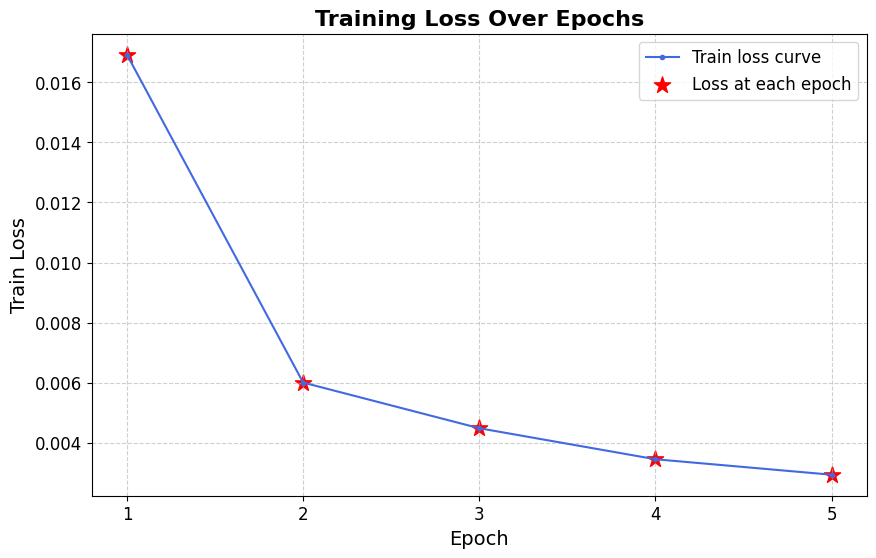

In [6]:
epochs = [1, 2, 3, 4, 5]
train_losses = []

for epoch in epochs:
    checkpoint = torch.load(f'checkpoint_epoch_{epoch}.pth')
    train_losses.append(checkpoint['loss'])

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, color='royalblue', linestyle='-', marker='o', markersize=3, label="Train loss curve")
plt.scatter(epochs, train_losses, color='red', marker='*', s=150, label="Loss at each epoch")  # Увеличенные звездочки

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Train Loss", fontsize=14)
plt.title("Training Loss Over Epochs", fontsize=16, fontweight='bold')

plt.xticks(epochs, fontsize=12)  
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.show()


In [51]:
epoch = 2
model = AdaptiveUNetAttencion(in_channels=1, out_channels=1)

model.load_state_dict(torch.load(f"checkpoint_epoch_{epoch}.pth")['model_state_dict'])
model.eval()

def predict(image_path, model, device='cpu'):
    image = Image.open(image_path).convert('L')
    image_tensor = transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(image_tensor)
    return transforms.ToPILImage()(output.squeeze(0).cpu())

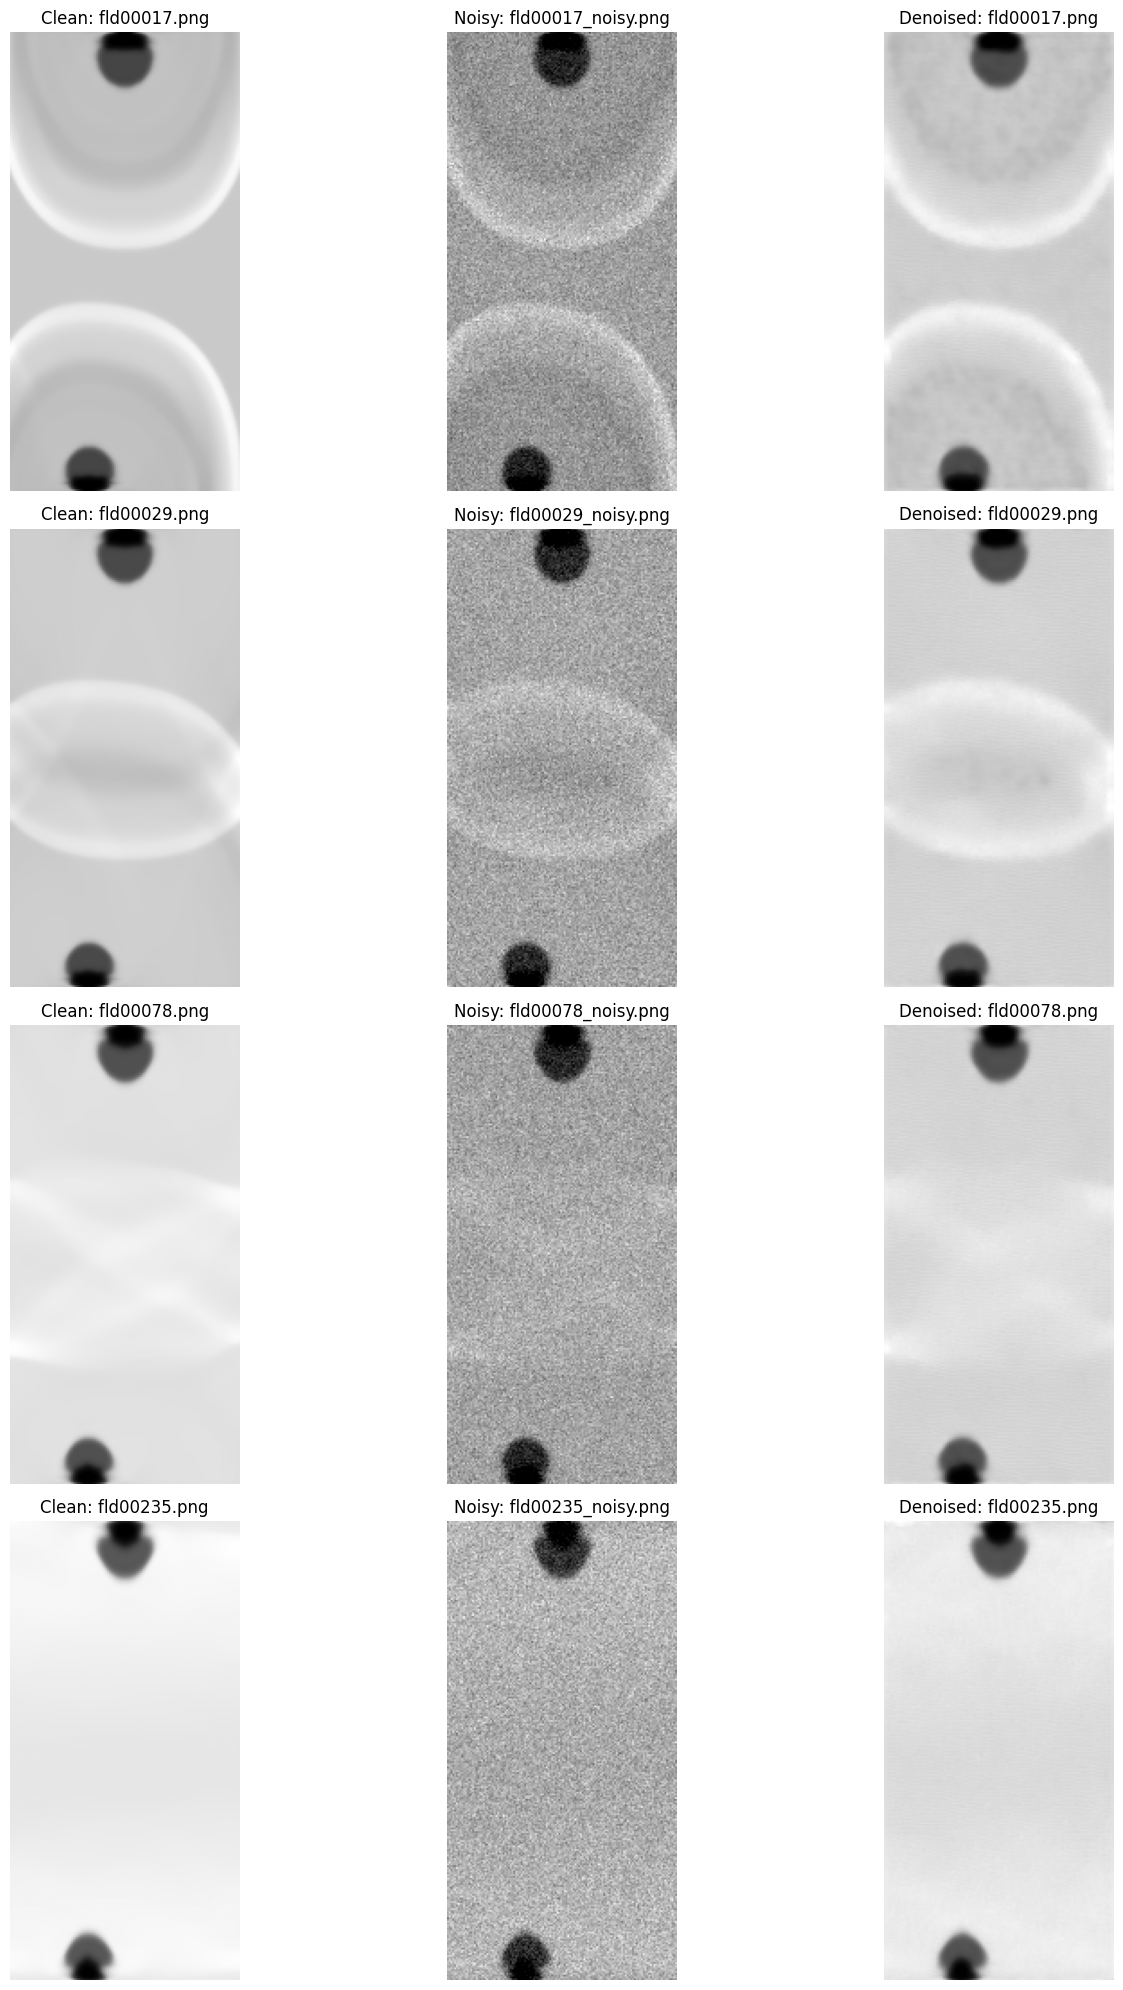

In [44]:
PATH_TO_TRAIN = Path(os.getcwd(), 'project_C++', 'Code', 'results_pictures_dataset')
list_images = ['fld00017_noisy.png', 'fld00029_noisy.png', 'fld00078_noisy.png', 'fld00235_noisy.png']

n_images = len(list_images)
fig, axes = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 5 * n_images))

if n_images == 1:
    axes = [axes]

for i, noisy_filename in enumerate(list_images):
    clean_filename = noisy_filename.replace('_noisy', '')
    
    noisy_path = Path(PATH_TO_TRAIN, noisy_filename)
    clean_path = Path(PATH_TO_TRAIN, clean_filename)
    
    clean_img = Image.open(clean_path).convert('L')
    noisy_img = Image.open(noisy_path).convert('L')
    
    denoised_img = predict(noisy_path, model)
    
    axes[i][0].imshow(clean_img, cmap='gray')
    axes[i][0].set_title(f"Clean: {clean_filename}")
    axes[i][0].axis('off')
    
    axes[i][1].imshow(noisy_img, cmap='gray')
    axes[i][1].set_title(f"Noisy: {noisy_filename}")
    axes[i][1].axis('off')
    
    axes[i][2].imshow(denoised_img, cmap='gray')
    axes[i][2].set_title(f"Denoised: {clean_filename}")
    axes[i][2].axis('off')

plt.tight_layout()
plt.show()

Теперь посмотрим как сеть себя показывает на экспериментальных картинках:

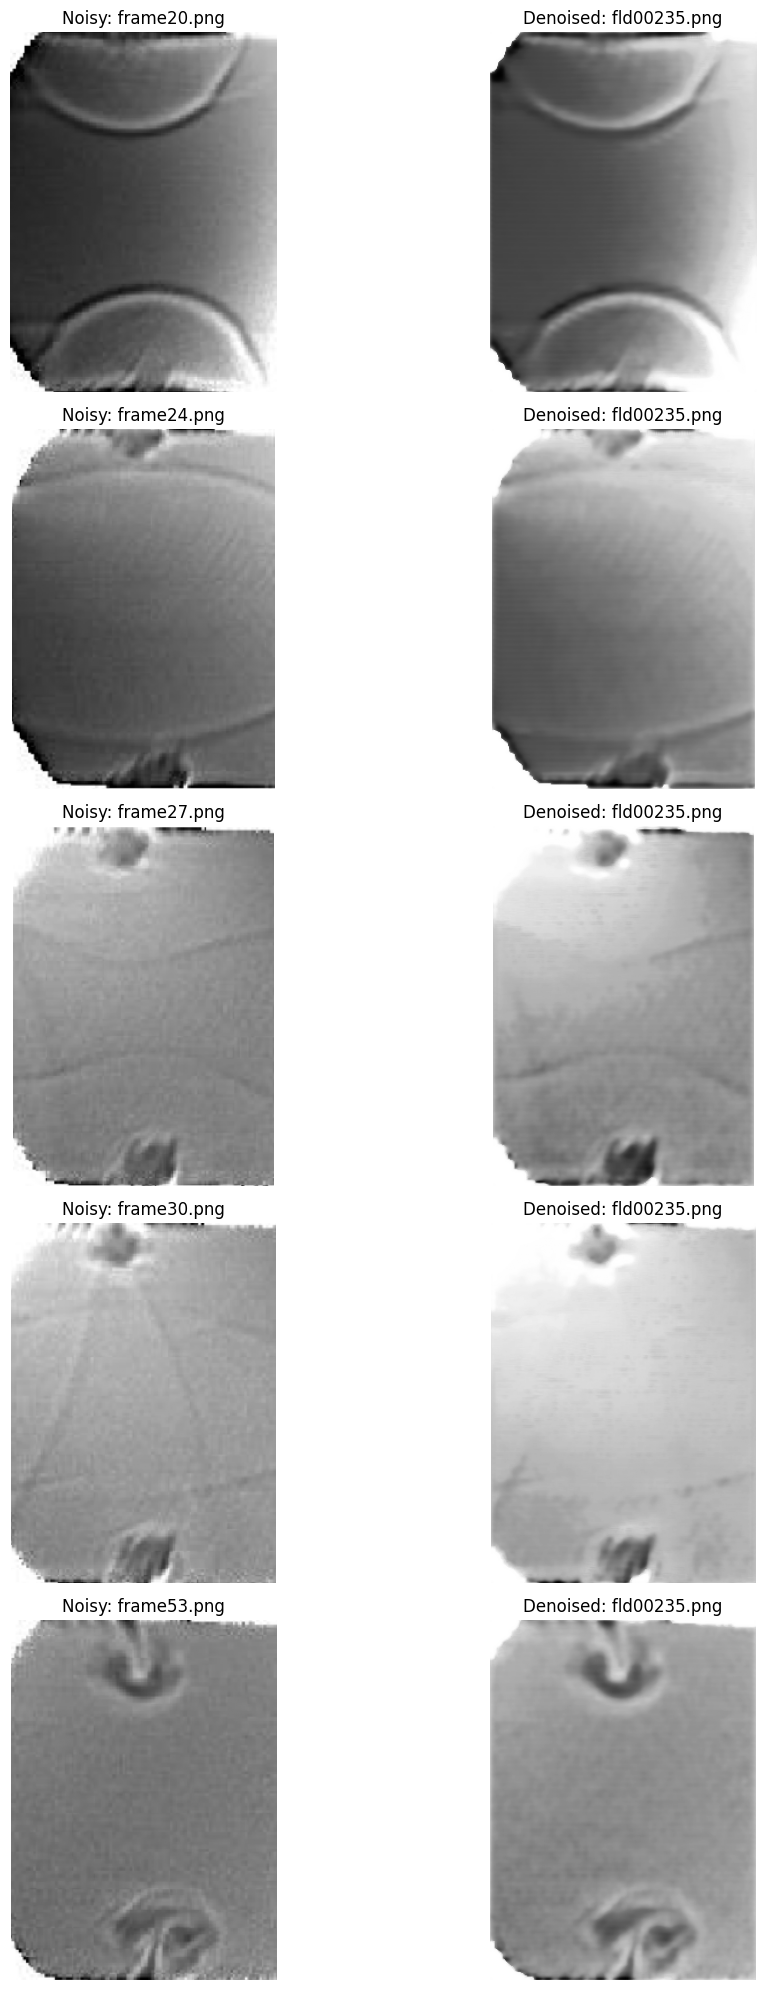

In [53]:
PATH_TO_TEST = str(Path(Path(os.getcwd()).parent, 'курсовая 4 курс/работа с картинками/ластовый эксперимент/экспериментальные 2'))
list_images = ['frame20.png', 'frame24.png', 'frame27.png', 'frame30.png', 'frame53.png']

n_images = len(list_images)
fig, axes = plt.subplots(nrows=n_images, ncols=2, figsize=(12, 4 * n_images))

if n_images == 1:
    axes = [axes]

for i, noisy_filename in enumerate(list_images):
    
    noisy_path = Path(PATH_TO_TEST, noisy_filename)
    
    noisy_img = Image.open(noisy_path).convert('L')
    
    denoised_img = predict(noisy_path, model)
    
    axes[i][0].imshow(noisy_img, cmap='gray')
    axes[i][0].set_title(f"Noisy: {noisy_filename}")
    axes[i][0].axis('off')
    
    axes[i][1].imshow(denoised_img, cmap='gray')
    axes[i][1].set_title(f"Denoised: {clean_filename}")
    axes[i][1].axis('off')

plt.tight_layout()
plt.show()

Проведя проверку для всех 5 эпох, заметил, что лучше всего работает нейронная сеть с весами, полученными после двух эпох обучения. Дальше на экспериментальных данных выходные картинки были хуже. То есть после второй эпохи пошло переобучение.

Возможно это связано с тем, что датасет не полностью отражал всю структуру шума с экспериментальных картинкок.
Нужно провести дальнейшее исследование на улучшение качества убирания шума (накладывать более сложный и случайный шум и тд).

# Save some results

In [28]:
PATH_TO_TRAIN = Path(os.getcwd(), 'project_C++', 'Code', 'results_pictures_dataset')
list_images = ['fld00017_noisy.png', 'fld00032_noisy_noisy_stretched_3.5x.png']
for i, path in enumerate(list_images):
    cur_path = str(Path(PATH_TO_TRAIN, path))
    output_image = predict(cur_path, model)
    output_image.save(str(Path('test pictures', 'train', f'second_model_train_{i}_epoch_2.png')))

In [29]:
PATH_TO_TEST = str(Path(Path(os.getcwd()).parent, 'курсовая 4 курс/работа с картинками/ластовый эксперимент/экспериментальные'))
list_images = ['frame24.png', 'frame53.png', 'frame30.png']
for i, path in enumerate(list_images):
    cur_path = str(Path(PATH_TO_TEST, path))
    output_image = predict(cur_path, model)
    output_image.save(str(Path('test pictures', 'test', f'second_model_test_{i}_epoch_2.png')))